<a href="https://colab.research.google.com/github/danielmunozji/Aprendizaje-de-m-quina/blob/main/Reto_Sangre_2200359_2120557_2200558.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reto Células de la Sangre**

Presentado Por:
*   Stiven Higuera Abadia. Código: 2200359
*   Jose David Daza Ayerve. Código: 2120557
*   Daniel Santiago Muñoz Jiménez. Código: 2200558




In [ ]:
#@title Librerias
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people

#Coloca aqui el resto de librerías que usaras en este Laboratorio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
from skimage.restoration import denoise_tv_chambolle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Carga de las imágenes

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


# Función para cargar datos desde subcarpetas
def load_data_from_subfolders(folder_path):
    data = []
    labels = []
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, filename)
                    img = cv2.imread(img_path)
                    # Preprocesamiento de la imagen (por ejemplo, cambiar tamaño, normalizar píxeles)
                    img = cv2.resize(img, (100, 100))  # Cambiar tamaño a 100x100 píxeles
                    img = (img.astype(np.float32) * 255).astype(np.uint8)  # Normalizar píxeles a valores entre 0 y 1
                    data.append(img)
                    labels.append(subfolder)
    return np.array(data), np.array(labels)

# Ruta a las carpetas en Google Drive
train_folder_path = '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/Celulas_train'
test_folder_path = '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/Inference'


# Cargar datos de entrenamiento y prueba
X_train, y_train = load_data_from_subfolders(train_folder_path)
X_test, y_test = load_data_from_subfolders(test_folder_path)

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Dividir los datos de entrenamiento en entrenamiento y validación
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Dimensiones de los datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (120, 100, 100, 3)
Dimensiones de X_test: (10, 100, 100, 3)
Dimensiones de y_train: (120,)
Dimensiones de y_test: (10,)


In [ ]:
def filtro_pasas_altas(image):
    # Crear un kernel
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    # Aplicar el kernel usando filter2D
    imagen_pasa_altas = cv2.filter2D(image, -1, kernel)
    return imagen_pasa_altas

X_train_high_pass = np.array([filtro_pasas_altas(image) for image in X_train])

In [ ]:
imagen_rgb = cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY)
imagen_high_pass_rgb = cv2.cvtColor(X_train_high_pass[0], cv2.COLOR_BGR2GRAY)

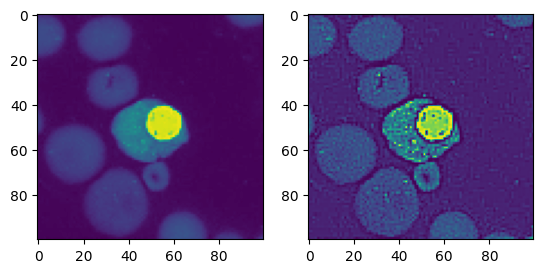

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(imagen_rgb)
plt.subplot(122)
plt.imshow(imagen_high_pass_rgb)
plt.show()

In [ ]:
X_train_fix = np.array([filtro_pasas_altas(image) for image in X_train])
X_test_fix = np.array([filtro_pasas_altas(img) for img in X_test])
X_train_val_fix = np.array([filtro_pasas_altas(image) for image in X_train_val])
X_test_val_fix = np.array([filtro_pasas_altas(img) for img in X_test_val])

In [ ]:
def recortar_imagen(image):
    return image[20:91, 20:91]

In [ ]:
X_train_cropped = np.array([recortar_imagen(image) for image in X_train_fix])
X_test_cropped = np.array([recortar_imagen(image) for image in X_test_fix])
X_train_val_cropped= np.array([recortar_imagen(image) for image in X_train_val_fix])
X_test_val_cropped = np.array([recortar_imagen(img) for img in X_test_val_fix])

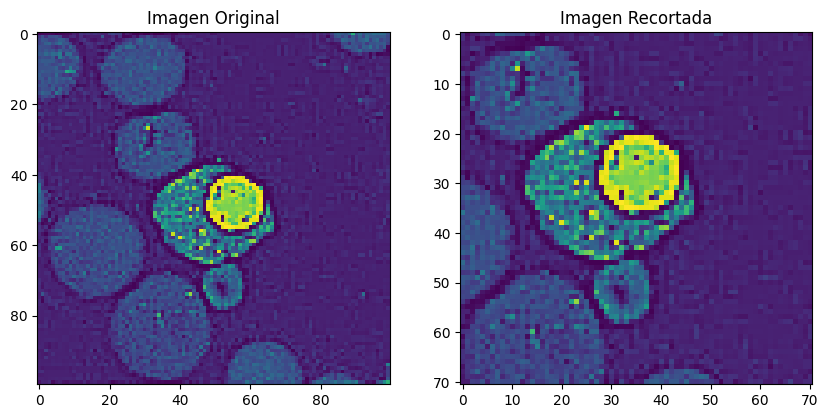

In [ ]:
# Mostrar la primera imagen original y recortada
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(X_train_fix[0], cv2.COLOR_BGR2GRAY))  # Mostrar la imagen original
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(X_train_cropped[0], cv2.COLOR_BGR2GRAY))  # Mostrar la imagen recortada
plt.title("Imagen Recortada")
plt.show()

In [ ]:
def convertir_a_escala_de_grises(imagenes):
    imagenes_grises = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imagenes]
    return np.array(imagenes_grises)

In [ ]:
X_train_cropped = convertir_a_escala_de_grises(X_train_cropped)
X_test_cropped = convertir_a_escala_de_grises(X_test_cropped)
X_train_val_cropped = convertir_a_escala_de_grises(X_train_val_cropped)
X_test_val_cropped = convertir_a_escala_de_grises(X_test_val_cropped)

In [ ]:
# Histograma Equalization
def compute_histogram(image, num_bins=256):
    bin_count, bins_edges = np.histogram(image, bins=num_bins, range=(0, 255))
    bins_start = bins_edges[:-1]
    return bins_start, bin_count

imagen_ejemplo = X_train_cropped[0]
histogram_start, histogram_count = compute_histogram(imagen_ejemplo)

In [ ]:
def draw_hist(x_axis, input, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    # Calcular el ancho de cada barra del histograma
    width = x_axis[1] - x_axis[0]
    ax.bar(x_axis, input, width=width, edgecolor='black')
    return fig, ax

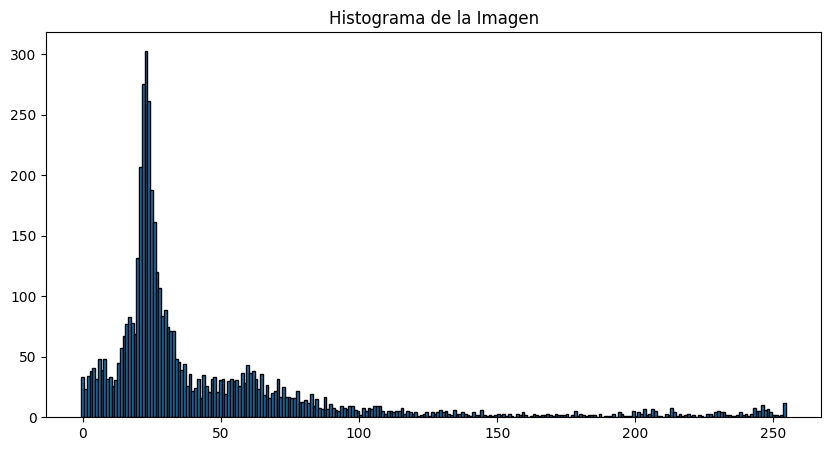

In [ ]:
fig, ax = draw_hist(histogram_start, histogram_count)
plt.title("Histograma de la Imagen")
plt.show()

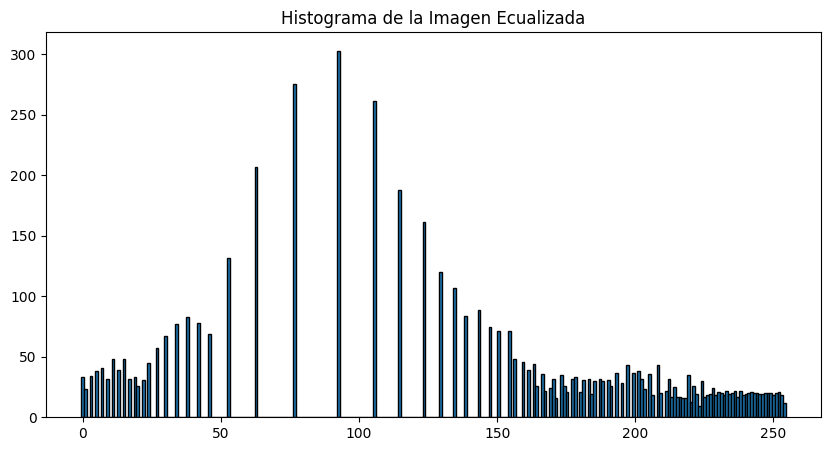

In [ ]:
imagen_ejemplo_ecualizada = cv2.equalizeHist(imagen_ejemplo)
histogram_start_ec, histogram_count_ec = compute_histogram(imagen_ejemplo_ecualizada)
fig, ax = draw_hist(histogram_start_ec, histogram_count_ec)
plt.title("Histograma de la Imagen Ecualizada")
plt.show()

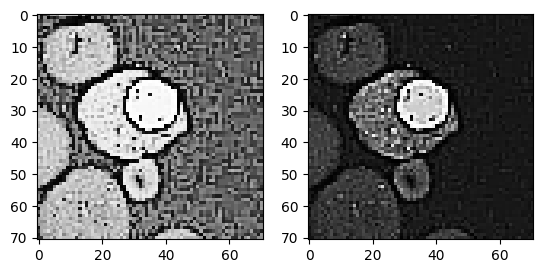

In [ ]:
plt.figure()
plt.subplot(121),plt.imshow(imagen_ejemplo_ecualizada,cmap="gray") #Los parametros son filas, columnas, y el puesto que se va a colocar el plot, como una matriz de izquierda a derecha y arriba a abajo
plt.subplot(122),plt.imshow(imagen_ejemplo,cmap="gray")
plt.show()

In [ ]:
def ecualizar_histograma(image):
    return cv2.equalizeHist(image)
X_train_cropped = np.array([ecualizar_histograma(img) for img in X_train_cropped])
X_test_cropped = np.array([ecualizar_histograma(img) for img in X_test_cropped])
X_train_val_cropped = np.array([ecualizar_histograma(image) for image in X_train_val_cropped])
X_test_val_cropped = np.array([ecualizar_histograma(img) for img in X_test_val_cropped])

In [ ]:
from skimage.feature import hog

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Asumiendo que las imágenes ya están en escala de grises
        if image.ndim == 3 and image.shape[2] == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Solo convertir si es necesario
        else:
            gray = image  # Usar la imagen tal como está si ya está en escala de grises

        # Calcular el descriptor HOG para la imagen
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
        hog_features.append(features)
    return np.array(hog_features)

# Extraer características HOG para conjuntos de entrenamiento, validación y prueba
X_train_hog = extract_hog_features(X_train_cropped)
X_test_hog = extract_hog_features(X_test_cropped)
X_train_val_hog = extract_hog_features(X_train_val_cropped)
X_test_val_hog = extract_hog_features(X_test_val_cropped)

# Dimensiones de los datos de características HOG
print("Dimensiones de características HOG de X_train:", X_train_hog.shape)
print("Dimensiones de características HOG de X_test:", X_test_hog.shape)

Dimensiones de características HOG de X_train: (120, 1764)
Dimensiones de características HOG de X_test: (10, 1764)


In [ ]:
# Entrenar el MLP
mlpHOG = MLPClassifier(hidden_layer_sizes=(515, 258, 130), activation='relu', solver='adam',
                       alpha=0.0001, batch_size='auto', learning_rate='constant',
                       max_iter=200, random_state=0, verbose=True, early_stopping=False)
mlpHOG.fit(X_train_hog, y_train)

# Predecir usando características de prueba
y_pred3 = mlpHOG.predict(X_test_hog)

# Calcular precisión y reporte de clasificación
accuracy2 = accuracy_score(y_test, y_pred3)
precision2 = precision_score(y_test, y_pred3, average=None)
recall2 = recall_score(y_test, y_pred3, average=None)
f12 = f1_score(y_test, y_pred3, average=None)
report2 = classification_report(y_test, y_pred3)

print("Accuracy:", accuracy2)
print("Precision Por Clase:", precision2)
print("Recall Por Clase:", recall2)
print("F1 Score Por Clase:", f12)
print("Classification Report:")
print(report2)

Iteration 1, loss = 0.70845950
Iteration 2, loss = 0.65582458
Iteration 3, loss = 0.64399991
Iteration 4, loss = 0.52514126
Iteration 5, loss = 0.46490916
Iteration 6, loss = 0.38643205
Iteration 7, loss = 0.28932552
Iteration 8, loss = 0.24150908
Iteration 9, loss = 0.16442707
Iteration 10, loss = 0.12255355
Iteration 11, loss = 0.09780448
Iteration 12, loss = 0.06502398
Iteration 13, loss = 0.05473148
Iteration 14, loss = 0.03485382
Iteration 15, loss = 0.02751695
Iteration 16, loss = 0.01995303
Iteration 17, loss = 0.01284024
Iteration 18, loss = 0.01119246
Iteration 19, loss = 0.00763408
Iteration 20, loss = 0.00477949
Iteration 21, loss = 0.00396552
Iteration 22, loss = 0.00348555
Iteration 23, loss = 0.00261815
Iteration 24, loss = 0.00181040
Iteration 25, loss = 0.00134707
Iteration 26, loss = 0.00114256
Iteration 27, loss = 0.00105985
Iteration 28, loss = 0.00101223
Iteration 29, loss = 0.00095963
Iteration 30, loss = 0.00089377
Iteration 31, loss = 0.00082251
Iteration 32, los

In [ ]:
print(X_test_cropped.size)
print(X_test_cropped.shape)
print(X_test_cropped.dtype)

print(X_test_val_cropped.size)
print(X_test_val_cropped.shape)
print(X_test_val_cropped.dtype)

50410
(10, 71, 71)
uint8
120984
(24, 71, 71)
uint8


In [ ]:
y_pred4 = mlpHOG.predict(X_test_val_hog)
probabilities = mlpHOG.predict_proba(X_test_val_hog)
# Calcular precisión y reporte de clasificación
accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3, average=None)
recall3 = recall_score(y_test, y_pred3, average=None)
f13 = f1_score(y_test, y_pred3, average=None)
report3 = classification_report(y_test, y_pred3)

print("Accuracy:", accuracy3)
print("Precision Por Clase:", precision3)
print("Recall Por Clase:", recall3)
print("F1 Score Por Clase:", f13)
print("Classification Report:")
print(report3)

Accuracy: 1.0
Precision Por Clase: [1. 1.]
Recall Por Clase: [1. 1.]
F1 Score Por Clase: [1. 1.]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_112418.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_163898.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_18821.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_4118.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_474348.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_564254.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_6162.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_8742.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_153470.jpg
Cargando imagen desde: /content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_300293

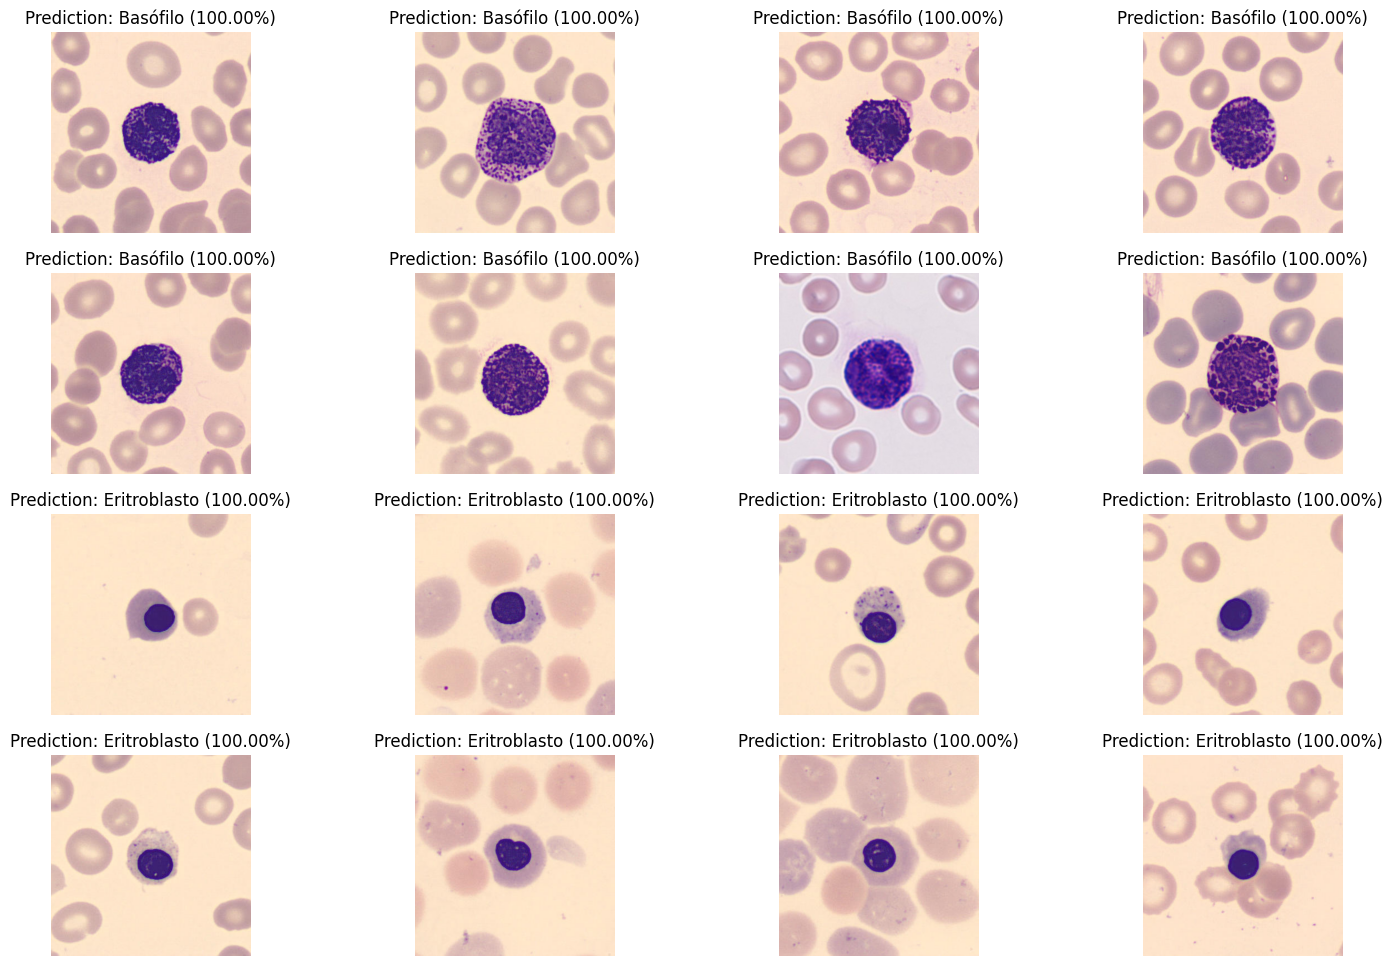

In [ ]:
def PreprocesarImagenes(image_paths):
    features = []  # características HOG
    for path in image_paths:
        try:
            print(f"Cargando imagen desde: {path}")

            # Cargar la imagen
            img = imread(path)

            # Convertir a escala de grises
            if img.ndim == 3:
                img = rgb2gray(img)

            # Redimensionar la imagen
            img_resized = resize(img, (50, 37, 1))

            img_resized = (img_resized * 255).astype(np.uint8)
            # Ecualización de histograma
            img_eq = ecualizar_histograma(img_resized)

            # Aplicar filtro de paso alto para resaltar bordes
            img_final = filtro_pasas_altas(img_eq)

            # Extraer características HOG de la imagen final procesada
            fd = hog(img_final, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

            # Agregar características a la lista de características
            features.append(fd)
        except Exception as e:
            print(f"Error al procesar la imagen '{path}': {e}")

    return features



# Rutas de las imágenes
image_paths = [
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_112418.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_163898.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_18821.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_4118.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_474348.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_564254.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_6162.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de BA_8742.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_153470.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_300293.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_32413.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_65895.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_768908.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_80122.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_92771.jpg',
    '/content/drive/MyDrive/ESPECIALIZACIÓN/CELULAS/PRUEBA/Copia de ERB_95333.jpg',
]

preprocessed_images = PreprocesarImagenes(image_paths)
labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


# Definir nombres de las clases
class_names = ['Basófilo', 'Eritroblasto']

# Cargar el modelo
mlpHOG = MLPClassifier(hidden_layer_sizes=(515, 258, 130), activation='relu', solver='adam',
                       alpha=0.0001, batch_size='auto', learning_rate='constant',
                       max_iter=200, random_state=0, verbose=True, early_stopping=False)

mlpHOG.fit(preprocessed_images, labels)

predictions = mlpHOG.predict(preprocessed_images)

# Obtener las probabilidades de las predicciones
probabilities = mlpHOG.predict_proba(preprocessed_images)

# Mostrar las imágenes y las predicciones
fig, axes = plt.subplots(4, 4, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(imread(image_paths[i]), cmap='gray')
    predicted_class = predictions[i]
    probability = np.max(probabilities[i]) * 100
    ax.set_title(f"Prediction: {class_names[predicted_class]} ({probability:.2f}%)")
    ax.axis('off')

plt.show()